<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/predict_market_price/Predicting_market_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta

In [4]:
data = yf.download(tickers = '^RUI', start = '2012-03-11', end = '2022-07-10')
data.head

[*********************100%%**********************]  1 of 1 completed


<bound method NDFrame.head of                    Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-03-12   759.429993   760.619995   756.840027   759.130005   759.130005   
2012-03-13   761.450012   773.030029   761.450012   772.979980   772.979980   
2012-03-14   773.190002   774.679993   769.280029   771.630005   771.630005   
2012-03-15   772.380005   776.469971   770.739990   776.419983   776.419983   
2012-03-16   776.559998   778.099976   775.640015   777.130005   777.130005   
...                 ...          ...          ...          ...          ...   
2022-07-01  2075.000000  2101.600098  2059.290039  2099.540039  2099.540039   
2022-07-05  2092.550049  2106.070068  2053.879883  2105.659912  2105.659912   
2022-07-06  2106.159912  2124.419922  2091.699951  2110.409912  2110.409912   
2022-07-07  2115.949951  2148.350098  2115.949951  2144.300049  2144.300049   
2022-07-08  2141.18994

In [5]:
data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=20)
data['EMAM '] = ta.ema(data.Close, length=100)
data['EMAS '] = ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close'] - data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [6]:
data_set = data.iloc[:,0:11]
pd.set_option('display.max_columns', None)

data_set.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,791.440002,795.679993,789.760010,789.760010,46.877256,795.406526,775.179523,762.677734,-2.690002,0,787.179993
1,789.869995,792.669983,785.640015,787.179993,44.575540,794.623046,775.417156,763.002267,6.260010,1,793.440002
2,787.179993,794.020020,786.260010,793.440002,50.849388,794.510376,775.774044,763.405416,7.019958,1,801.599976
3,794.580017,801.859985,794.580017,801.599976,57.558969,795.185576,776.285448,763.911304,4.369995,1,805.039978
4,800.669983,805.770020,800.669983,805.039978,60.023875,796.124090,776.854845,764.456055,-0.809998,0,803.330017


In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
data_set_scaled

array([[0.02295817, 0.02294337, 0.02477161, ..., 0.61254467, 0.        ,
        0.02075971],
       [0.02213767, 0.02137597, 0.02261574, ..., 0.64462357, 1.        ,
        0.02403152],
       [0.02073185, 0.02207898, 0.02294016, ..., 0.6473474 , 1.        ,
        0.02829634],
       ...,
       [0.70292872, 0.70530315, 0.68624737, ..., 0.63741923, 1.        ,
        0.71234811],
       [0.71004135, 0.71485848, 0.70603747, ..., 0.72379951, 1.        ,
        0.73006085],
       [0.7151577 , 0.72731964, 0.71872676, ..., 0.62397837, 1.        ,
        0.72869667]])

In [9]:
X = []

backandles = 30
print(data_set_scaled.shape[0])
for j in range(8):
  X.append([])
  for i in range(backandles, data_set_scaled.shape[0]):
    X[j].append(data_set_scaled[i-backandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(data_set_scaled[backandles:, -1])
y=np.reshape(yi, (len(yi),1))

2448


In [10]:
X.shape

(2418, 30, 8)

In [11]:
y.shape

(2418, 1)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
X_train.shape

(1934, 30, 8)

In [20]:
y_train.shape

(1934, 1)

In [21]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
116/116 [==============================] - 8s 43ms/step - loss: 0.0053 - val_loss: 4.5692e-04
Epoch 2/30
116/116 [==============================] - 3s 28ms/step - loss: 3.6759e-04 - val_loss: 3.5169e-04
Epoch 3/30
116/116 [==============================] - 3s 28ms/step - loss: 3.0154e-04 - val_loss: 2.8118e-04
Epoch 4/30
116/116 [==============================] - 5s 43ms/step - loss: 2.9221e-04 - val_loss: 2.4492e-04
Epoch 5/30
116/116 [==============================] - 3s 28ms/step - loss: 2.6042e-04 - val_loss: 2.3947e-04
Epoch 6/30
116/116 [==============================] - 3s 28ms/step - loss: 2.7459e-04 - val_loss: 2.2705e-04
Epoch 7/30
116/116 [==============================] - 4s 30ms/step - loss: 2.3508e-04 - val_loss: 2.2712e-04
Epoch 8/30
116/116 [==============================] - 5s 44ms/step - loss: 2.2473e-04 - val_loss: 2.3886e-04
Epoch 9/30
116/116 [==============================] - 3s 29ms/step - loss: 2.1038e-04 - val_loss: 2.0785e-04
Epoch 10/30
116/116 [==

In [24]:
y_pred = model.predict(X_test)
for i in range(10):
  print(y_pred[i], y_test[i])

16/16 [==============================] - 1s 16ms/step
[0.2555793] [0.2623659]
[0.4159433] [0.42309177]
[0.7745711] [0.73014966]
[0.47402337] [0.46485166]
[0.51697403] [0.50905752]
[0.2923216] [0.30023206]
[0.42949075] [0.43780966]
[0.5135969] [0.51710636]
[0.44079295] [0.4455501]
[0.24952501] [0.26827189]


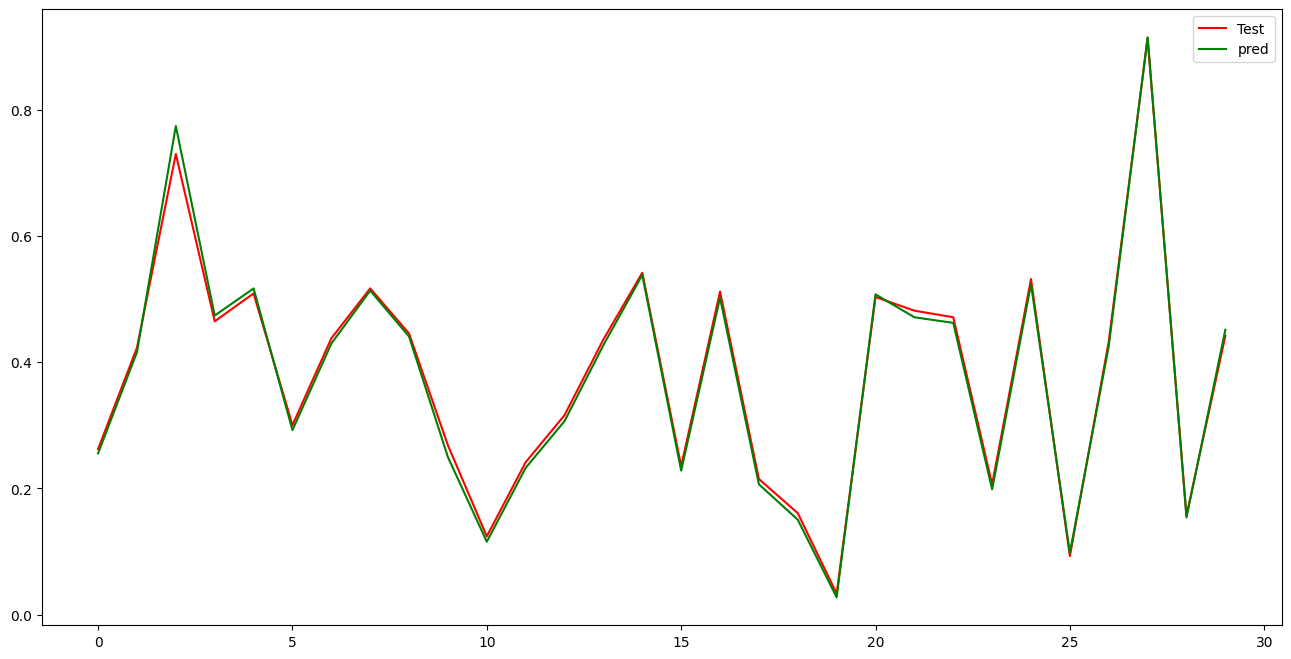

In [29]:
plt.figure(figsize = (16,8))
plt.plot(y_test[:30], color = 'red', label = 'Test')
plt.plot(y_pred[:30], color = 'green', label = 'pred')
plt.legend()
plt.show()